# Vision transformer dimensionality reduction

Turning ViT into a patch autoencoder.

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


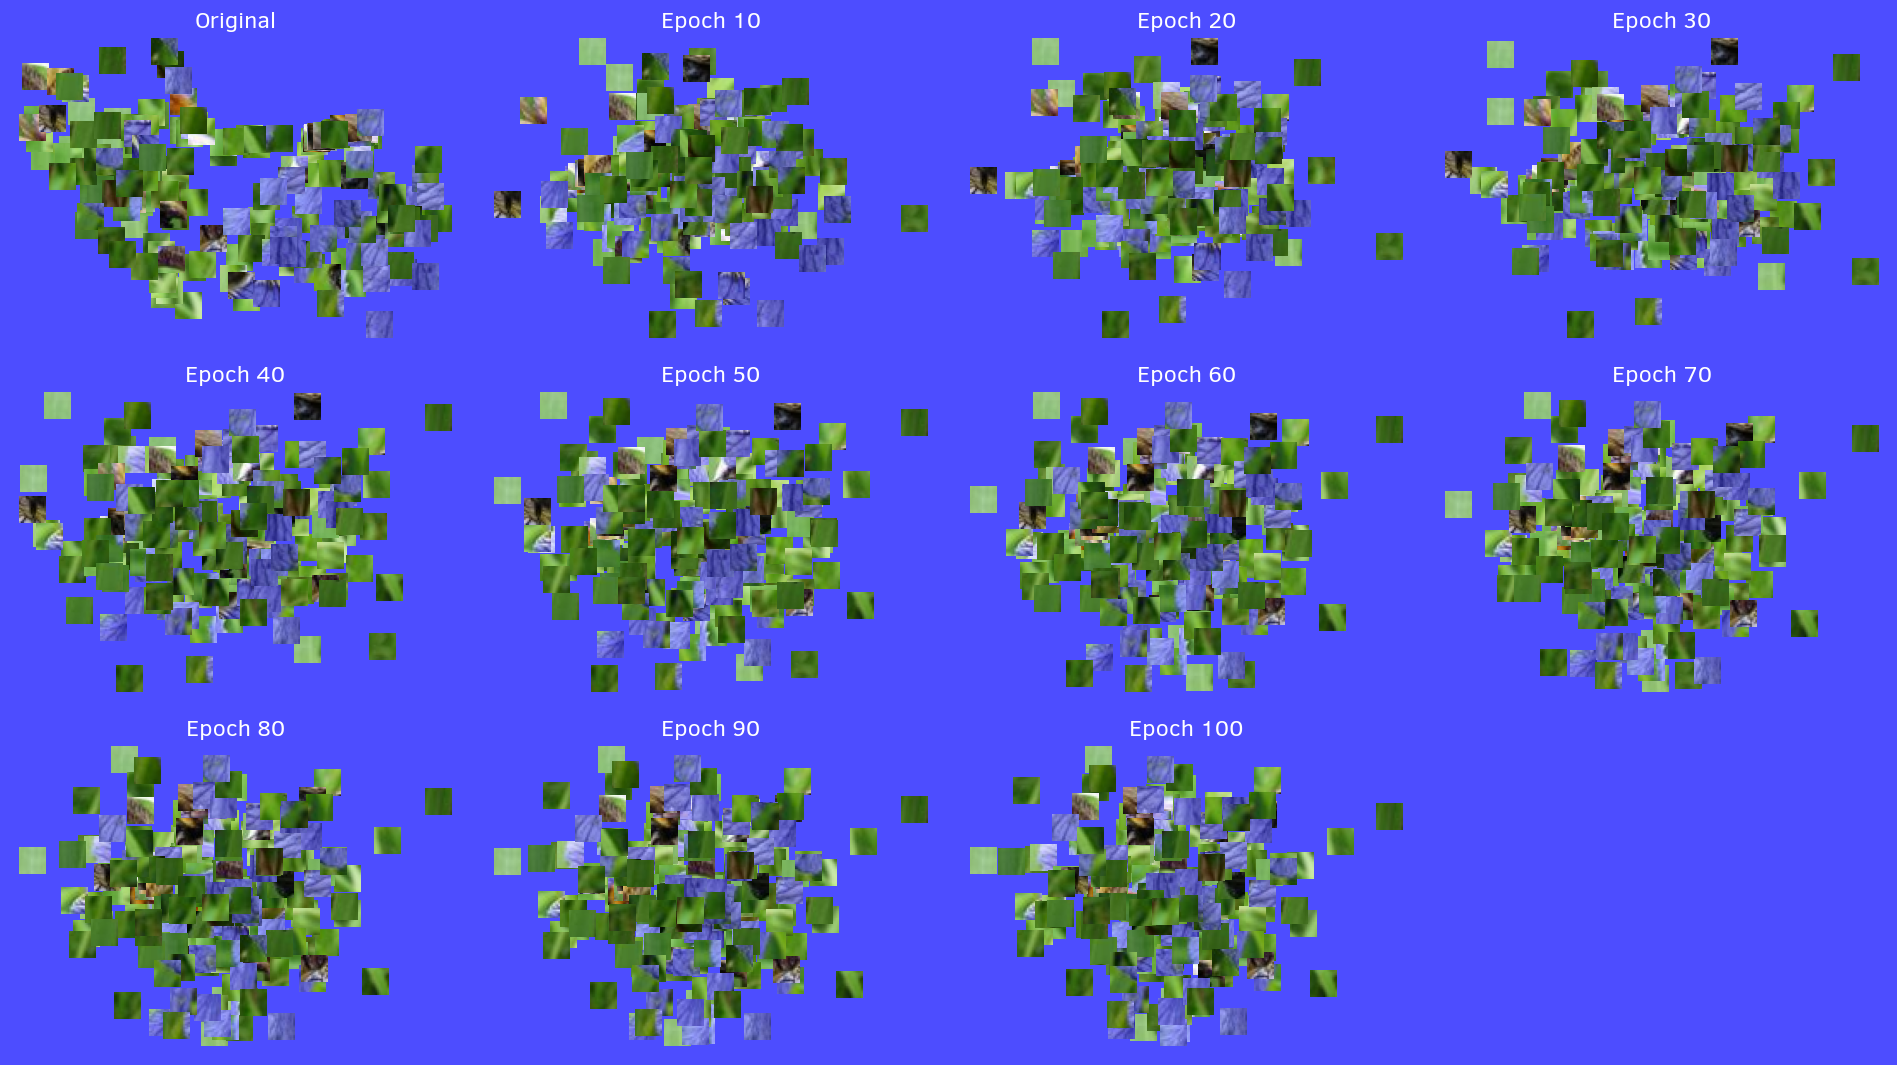

In [ ]:
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from torch import nn
from torchvision import transforms
from transformers import ViTConfig, ViTImageProcessor, ViTModel

# Tweak background
plt.rcParams["figure.facecolor"] = "#4d4dff"
plt.rcParams["axes.facecolor"] = "#4d4dff"

# Set device
device = (
    "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
)

# Config
image_dir = "../images/iris"
model_name = "google/vit-base-patch16-224"
epochs = 100  # Feel free to increase this
save_every = 10  # Save every N epochs

# Load and preprocess images
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith((".jpg", ".png"))])  # noqa: PTH208
images, pil_images = [], []

for fname in image_files:
    path = os.path.join(image_dir, fname)  # noqa: PTH118
    img = Image.open(path).convert("RGB")
    pil_images.append(img.resize((224, 224)))
    images.append(transform(img))

images = torch.stack(images).to(device)

# Load model and processor
processor = ViTImageProcessor.from_pretrained(model_name)
model = ViTModel.from_pretrained(model_name).to(device)

for param in model.parameters():
    param.requires_grad = True

# for name, param in model.named_parameters():
#     param.requires_grad = "encoder.layer.11" in name

# Create projection head (768 → ReLU → 2)
config = ViTConfig.from_pretrained(model_name)
head = nn.Sequential(
    nn.Linear(config.hidden_size, config.hidden_size),
    # nn.ReLU(),
    nn.Linear(config.hidden_size, 2),
).to(device)
head.apply(lambda m: nn.init.xavier_uniform_(m.weight) if isinstance(m, nn.Linear) else None)

optimizer = torch.optim.AdamW(head.parameters(), lr=1e-5)
loss_fn = nn.MSELoss()

# Create random 2D targets
num_images = len(images)
target_proj = torch.randn(num_images, 196, 2, device=device)

# Store patch embeddings per epoch
embedding_history = []

for epoch in range(epochs + 1):
    current_embeddings = []
    head.eval()
    with torch.no_grad():
        for img in images:
            inputs = processor(images=img.unsqueeze(0), return_tensors="pt").to(device)
            tokens = model(**inputs).last_hidden_state[:, 1:, :]
            out = head(tokens).squeeze(0).cpu().numpy()
            current_embeddings.append(out)
    if epoch % save_every == 0 or epoch == epochs:
        embedding_history.append(np.stack(current_embeddings)[0])  # First image

    if epoch == epochs:
        break

    head.train()
    for i, img in enumerate(images):
        inputs = processor(images=img.unsqueeze(0), return_tensors="pt").to(device)
        with torch.no_grad():
            tokens = model(**inputs).last_hidden_state[:, 1:, :]
        preds = head(tokens)
        loss = loss_fn(preds, target_proj[i : i + 1])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch}, Image {i}, Loss: {loss.item():.4f}", end="\r")


# Plot projections
coords = [(i // 14, i % 14) for i in range(196)]
patch_size = 16
image_resized = pil_images[0]
num_plots = len(embedding_history)
cols = 4
rows = math.ceil(num_plots / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3), dpi=120)
axes = axes.flatten()

plt.style.use("dark_background")
plt.rcParams["font.family"] = "Clear Sans"

for i, emb in enumerate(embedding_history):
    proj = emb
    proj = (proj - proj.min(0)) / (proj.max(0) - proj.min(0))  # normalize to [0, 1]
    proj = proj * 2 - 1  # scale to [-1, 1]

    ax = axes[i]
    ax.set_title(f"Epoch {i * save_every}" if i > 0 else "Original", fontsize=14)
    ax.scatter(proj[:, 0], proj[:, 1], alpha=0)

    for j, (x, y) in enumerate(proj):
        row, col = j // 14, j % 14
        patch = image_resized.crop(
            (col * patch_size, row * patch_size, (col + 1) * patch_size, (row + 1) * patch_size)
        )
        ab = AnnotationBbox(OffsetImage(patch, zoom=1.0), (x, y), frameon=False)
        ax.add_artist(ab)

    ax.axis("off")

for j in range(len(embedding_history), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

You are using a model of type vit_mae to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.
Some weights of ViTModel were not initialized from the model checkpoint at facebook/vit-mae-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/500 | Loss: 0.0460
Epoch 101/500 | Loss: 0.0121
Epoch 201/500 | Loss: 0.0097
Epoch 301/500 | Loss: 0.0086
Epoch 401/500 | Loss: 0.0071
Epoch 500/500 | Loss: 0.0061


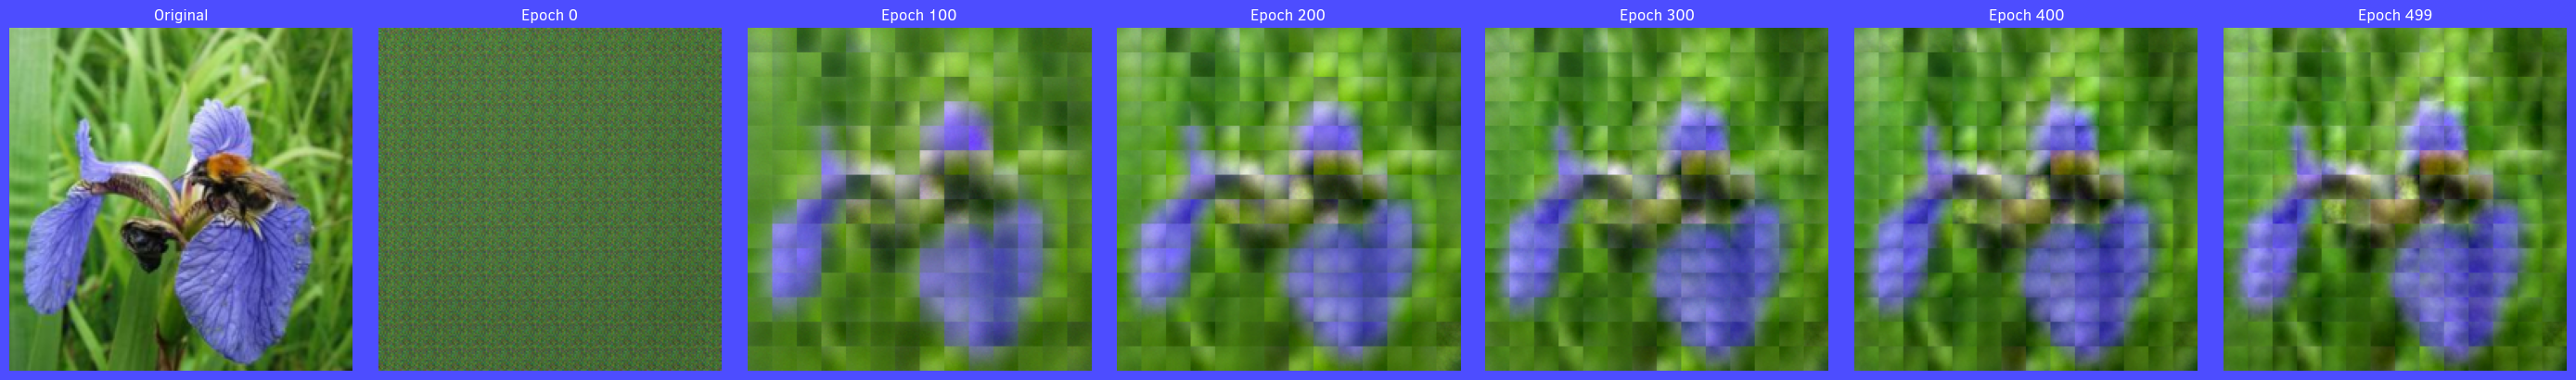

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
from transformers import ViTImageProcessor, ViTModel

# --- Config ---
image_dir = "../images/iris"
# model_name = "google/vit-base-patch16-224"
model_name = "facebook/vit-mae-base"
device = torch.device(
    "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
)
epochs = 500
save_every = 100
lr = 1e-3

# --- Load images ---
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith((".jpg", ".png"))])  # noqa: PTH208
images = []
for fname in image_files:
    path = os.path.join(image_dir, fname)  # noqa: PTH118
    img = Image.open(path).convert("RGB")
    images.append(transform(img))
images = torch.stack(images).to(device)

# --- Load ViT model ---
processor = ViTImageProcessor.from_pretrained(model_name)
model = ViTModel.from_pretrained(model_name).to(device)

# for param in model.parameters():
#     param.requires_grad = False  # freeze backbone

for name, param in model.named_parameters():
    param.requires_grad = "encoder.layer.11" in name or "encoder.layer.10" in name

# Decoder head (768 -> 3*16*16)
patch_dim = 3 * 16 * 16
# decoder = nn.Linear(model.config.hidden_size, patch_dim).to(device)
decoder = nn.Sequential(nn.Linear(768, 1024), nn.ReLU(), nn.Linear(1024, patch_dim)).to(device)
optimizer = torch.optim.AdamW(decoder.parameters(), lr=lr)
loss_fn = nn.SmoothL1Loss()

# Reconstruction function
reconstructions = []
saved_epochs = []

# Training loop
for epoch in range(epochs):
    decoder.train()
    total_loss = 0
    for img in images:
        img = img.unsqueeze(0)  # (1, 3, 224, 224)
        inputs = processor(images=img, return_tensors="pt").to(device)
        with torch.no_grad():
            tokens = model(**inputs).last_hidden_state[:, 1:, :]  # (1, 196, 768)
        preds = decoder(tokens).squeeze(0)  # (196, 768)

        # Ground truth patches
        patches = img.squeeze(0).unfold(1, 16, 16).unfold(2, 16, 16)
        patches = patches.permute(1, 2, 0, 3, 4).reshape(196, patch_dim).to(device)

        loss = loss_fn(preds, patches)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Log reconstructions every few epochs
    if epoch % save_every == 0 or epoch == epochs - 1:
        decoder.eval()
        with torch.no_grad():
            ref_img = images[0].unsqueeze(0)
            tokens = model(
                **processor(images=ref_img, return_tensors="pt").to(device)
            ).last_hidden_state[:, 1:, :]
            recon = decoder(tokens).reshape(1, 14, 14, 3, 16, 16)
            recon = recon.permute(0, 3, 1, 4, 2, 5).reshape(1, 3, 224, 224).clamp(0, 1).squeeze(0)
            reconstructions.append(recon.cpu())
            saved_epochs.append(epoch)
            print(f"Epoch {epoch + 1}/{epochs} | Loss: {total_loss / len(images):.4f}")

# --- Reconstruct one image ---
decoder.eval()
model.eval()
img = images[1].unsqueeze(0)
inputs = processor(images=img, return_tensors="pt").to(device)
with torch.no_grad():
    tokens = model(**inputs).last_hidden_state[:, 1:, :]  # (1, 196, 768)
    decoded = decoder(tokens).reshape(1, 14, 14, 3, 16, 16)
    decoded = decoded.permute(0, 3, 1, 4, 2, 5).reshape(1, 3, 224, 224).clamp(0, 1).squeeze(0)

# Plot original + intermediate reconstructions
fig, axes = plt.subplots(1, len(reconstructions) + 1, figsize=(4 * (len(reconstructions) + 1), 4))

# Show original
axes[0].imshow(images[0].permute(1, 2, 0).cpu())
axes[0].set_title("Original")
axes[0].axis("off")

# Show reconstructions
for i, rec in enumerate(reconstructions):
    axes[i + 1].imshow(rec.permute(1, 2, 0))
    axes[i + 1].set_title(f"Epoch {saved_epochs[i]}")
    axes[i + 1].axis("off")

plt.tight_layout()
plt.show()